In [ ]:
import pandas as pd 


In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('french'))
from bs4 import BeautifulSoup
import string
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data =pd.read_csv('data.csv')

In [ ]:
data.drop("Unnamed: 0",axis=1,inplace=True)

In [ ]:
data.head()


,comments,notes,hotel_name
0,"C'est un superbe hotel très très propre, très...",10.0,Hotel Princesse Ilham
1,Merci pour tout ce que vous avez fait pour no...,10.0,Hotel Princesse Ilham
2,"L'établissement est propre, personnel très se...",8.0,Hotel Princesse Ilham
3,"l’emplacement, la propreté, la décoration, le...",10.0,Hotel Princesse Ilham
4,rapport prix qualité,7.0,Hotel Princesse Ilham


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2034 entries, 0 to 2033
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   comments    2034 non-null   object 
 1   notes       2034 non-null   float64
 2   hotel_name  2034 non-null   object 
dtypes: float64(1), object(2)
memory usage: 47.8+ KB


In [ ]:

def sentiment(note):
  if(note<5):
    return 0
  elif(note<7):
    return 1
  else :
    return 2

In [ ]:
data.notes=data.notes.apply(sentiment)

In [ ]:
data.head()

,comments,notes,hotel_name
0,"C'est un superbe hotel très très propre, très...",2,Hotel Princesse Ilham
1,Merci pour tout ce que vous avez fait pour no...,2,Hotel Princesse Ilham
2,"L'établissement est propre, personnel très se...",2,Hotel Princesse Ilham
3,"l’emplacement, la propreté, la décoration, le...",2,Hotel Princesse Ilham
4,rapport prix qualité,2,Hotel Princesse Ilham


In [ ]:
hotels=(data.groupby('hotel_name').sum()/data.groupby('hotel_name').count()).index
averages=(data.groupby('hotel_name').sum()/data.groupby('hotel_name').count())['notes']

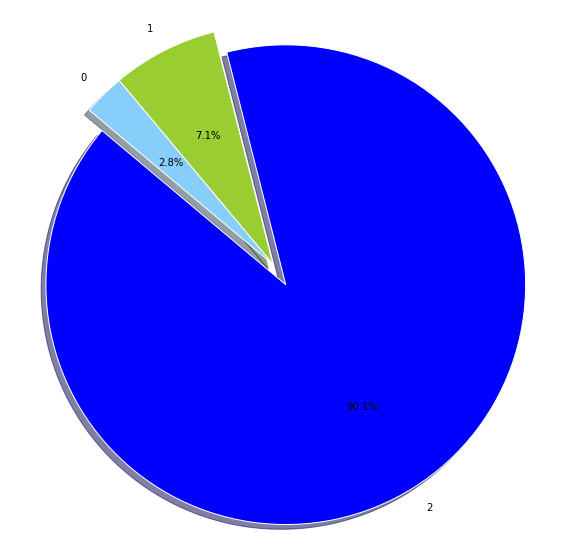

In [ ]:
labels = list(data.notes.value_counts().index)
sizes = list(data.notes.value_counts().values)
colors = ['blue','yellowgreen', 'lightskyblue']
explode = (0.1, 0,0)  # explode 1st slice

# Plot
plt.figure(figsize=(10,10))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140, wedgeprops={"edgecolor":"white"})
plt.axis('equal')
plt.show()

In [ ]:
print(data[data['notes']==0].shape[0] , " negative comments " ) 
print(data[data['notes']==1].shape[0], " neutral comments ")
print(data[data['notes']==2].shape[0], " positive comments ")

57  negative comments 
145  neutral comments 
1832  positive comments 


In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation, remove words containing numbers, remove stop words and Xs.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [ ]:
data.comments=data.comments.apply(clean_text)

In [ ]:
data.head()

,comments,notes,hotel_name
0,cest superbe hotel très très propre très confo...,2,Hotel Princesse Ilham
1,merci tout fait,2,Hotel Princesse Ilham
2,létablissement propre personnel très serviable...,2,Hotel Princesse Ilham
3,l’emplacement propreté décoration personnel pe...,2,Hotel Princesse Ilham
4,rapport prix qualité,2,Hotel Princesse Ilham


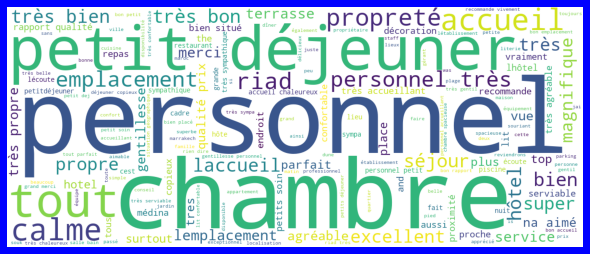

In [ ]:
text = " ".join(comment for comment in data["comments"])
wordcloud = WordCloud(width = 1200, height = 500, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(text) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = 'b') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
number_words = [len(comments.split(' ')) for comments in data["comments"]]


### Most comments have 10 or less words

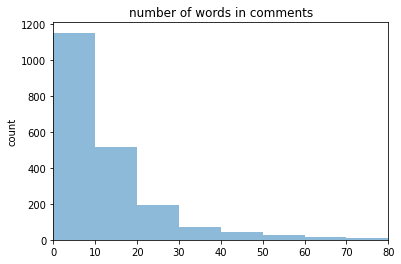

In [ ]:
bins = np.arange(-0, 3000, 10) # fixed bin size

plt.xlim([0, 80])

plt.hist( number_words, bins=bins, alpha=0.5)
plt.title('number of words in comments')
plt.ylabel('count')

plt.show()

## LSTM 

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50
# This is fixed.
EMBEDDING_DIM = 5

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['comments'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.Q' % len(word_index))

Found 4992 unique tokens.Q


In [ ]:
X = tokenizer.texts_to_sequences(data['comments'].values)#list of integers
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) #padding
print('Shape of data tensor:', X.shape)

Shape of data tensor: (2034, 50)


In [ ]:
labels = list(pd.get_dummies(data['notes']).columns)
Y = pd.get_dummies(data['notes']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (2034, 3)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1627, 50) (1627, 3)
(407, 50) (407, 3)


## Model 


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 5)             25        
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 50, 5)            0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 10)                640       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 698
Trainable params: 698
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 10
batch_size = 20
# Code Here
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
74/74 [==============================] - 7s 54ms/step - loss: 0.7979 - accuracy: 0.8907 - val_loss: 0.4295 - val_accuracy: 0.9141
Epoch 2/10
74/74 [==============================] - 3s 44ms/step - loss: 0.4134 - accuracy: 0.8934 - val_loss: 0.3758 - val_accuracy: 0.9141
Epoch 3/10
74/74 [==============================] - 4s 48ms/step - loss: 0.4051 - accuracy: 0.8934 - val_loss: 0.3704 - val_accuracy: 0.9141
Epoch 4/10
74/74 [==============================] - 3s 46ms/step - loss: 0.4049 - accuracy: 0.8934 - val_loss: 0.3669 - val_accuracy: 0.9141
Epoch 5/10
74/74 [==============================] - 3s 45ms/step - loss: 0.4027 - accuracy: 0.8934 - val_loss: 0.3647 - val_accuracy: 0.9141
Epoch 6/10
74/74 [==============================] - 3s 46ms/step - loss: 0.4005 - accuracy: 0.8934 - val_loss: 0.3638 - val_accuracy: 0.9141
Epoch 7/10
74/74 [==============================] - 3s 47ms/step - loss: 0.4008 - accuracy: 0.8934 - val_loss: 0.3615 - val_accuracy: 0.9141
Epoch 8/10
74

In [ ]:
from statistics import mean
score = [mean(history.history['loss']),mean(history.history['accuracy']) ]
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0],score[1]))

Test set
  Loss: 0.44
  Accuracy: 0.89


In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
predicted_classes = np.argmax(Y_pred, axis=1)

In [ ]:
expected_classes = np.argmax(Y_test, axis=1)

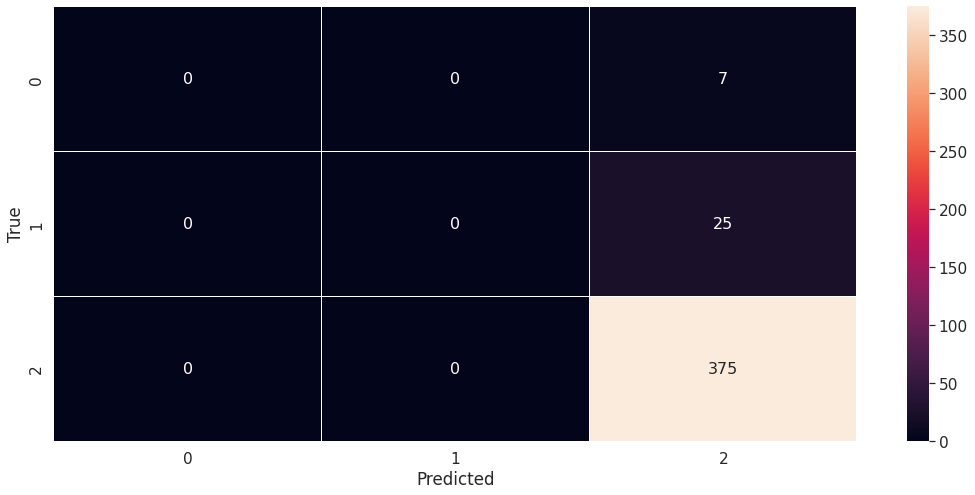

In [ ]:
cm = confusion_matrix(expected_classes, predicted_classes)
plt.figure(figsize=(18,8))
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='d',linewidths=0.5, xticklabels=labels, yticklabels=labels) 
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

array([[   0,    0,    0, ..., 4509,  564, 4510],
       [   0,    0,    0, ..., 4638,    3,    6],
       [   0,    0,    0, ...,   52,   89,  439],
       ...,
       [   0,    0,    0, ...,  191, 3358, 3359],
       [   0,    0,    0, ...,   84,    1,  276],
       [   0,    0,    0, ..., 3738,  300, 3739]], dtype=int32)

In [ ]:
test = model.predict(X_test)

In [ ]:
def analyze_sentiment(comment):
  clean_text(comment)
  X = tokenizer.texts_to_sequences(comment)#list of integers
  X = pad_sequences(X, maxlen=50) #padding
  pred=model.predict(X)
  print(np.argmax(pred,axis=1))
  predicted_class = max(np.argmax(pred,axis=1))
  if(predicted_class==1):
    print("neutral comment")
  elif(predicted_class==2):
    print("positive comment")
  else:
    print("negative comment")


In [ ]:
analyze_sentiment("très bon hotel ")

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
positive comment
